In [1]:
# When comparing two data sets using statistical tools, it is not
# sufficient to simply compare their average or median values. This is because
# such results can be skewed by randomness. For example, suppose we are
# calculating the median values of ten seeds. If one algorithm gets "lucky"
# and happens to use more above-average seeds, the estimated median will
# be skewed. Therefore, it is necessary to check the statistical significance of
# results. This is exactly what the indifferent entries are displaying. To determine
# statistical significance, the Kruskal-Wallis and Mann-Whitney U tests with 95% confidence
# intervals can be used.

# The Kruskal-Wallis H-test tests the null hypothesis that the population median of all
# of the groups are equal. It is a non-parametric version of ANOVA.
# The test works on 2 or more independent samples, which may have different sizes.
# Note that rejecting the null hypothesis does not indicate which of the groups differs.
# Post hoc comparisons between groups are required to determine which groups are different.

In [2]:
import numpy as np
from scipy import stats
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]
sys.path.append("..")
import rbf_functions

In [3]:
rbfs = [
    rbf_functions.original_rbf,
    rbf_functions.squared_exponential_rbf,
    rbf_functions.inverse_quadratic_rbf,
    rbf_functions.inverse_multiquadric_rbf,
    rbf_functions.exponential_rbf,
    rbf_functions.matern32_rbf,
    rbf_functions.matern52_rbf,
]

In [4]:
name_mapping = {'original_rbf': "Modified squared\nexponential",
                 'squared_exponential_rbf':  "Squared exponential",
                 'inverse_quadratic_rbf': "Inverse quadratic",
                 'inverse_multiquadric_rbf': "Inverse Multiquadric",
                 'exponential_rbf': "Exponential",
                 'matern32_rbf': "Matern 32",
                 'matern52_rbf': "Matern 52"}

# Kruskal-Wallis HV local reference set

In [5]:
rbf_names = [rbf.__name__ for rbf in rbfs]
rbf_names_cleaned = [name_mapping[rbf] for rbf in rbf_names]

refsets = {}
for rbf, name in zip(rbf_names, rbf_names_cleaned):
    df_hv_data = pd.read_csv(f"refsets/{rbf}_refset.csv")
    refsets[name] = df_hv_data

In [6]:
objectives = refsets["Modified squared\nexponential"].columns.values.tolist()

In [7]:
import itertools
import collections


combinations = itertools.combinations(rbf_names_cleaned, 2)

index = pd.MultiIndex.from_product([rbf_names_cleaned, objectives])

results = pd.DataFrame(index=index, columns=rbf_names_cleaned)
for rbf_i, rbf_j in combinations:
    
    teststatistics = {}
    for obj in objectives:
        data_i_obj = refsets[rbf_i][obj]
        data_j_obj = refsets[rbf_j][obj]
        krusval, pval = stats.kruskal(data_i_obj, data_j_obj)
        results.loc[(rbf_i, obj), (rbf_j)]= pval 

    
results= results.fillna(0)

we can drop a row/column if desired using the code below

In [18]:
results = results.drop(columns="Modified squared\nexponential", index='Matern 52')

/var/folders/_t/l6cr0r0d1m108xdrmrtz7stsb_csl0/T/ipykernel_64466/1353616700.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  results = results.drop(columns="Modified squared\nexponential", index='Matern 52')


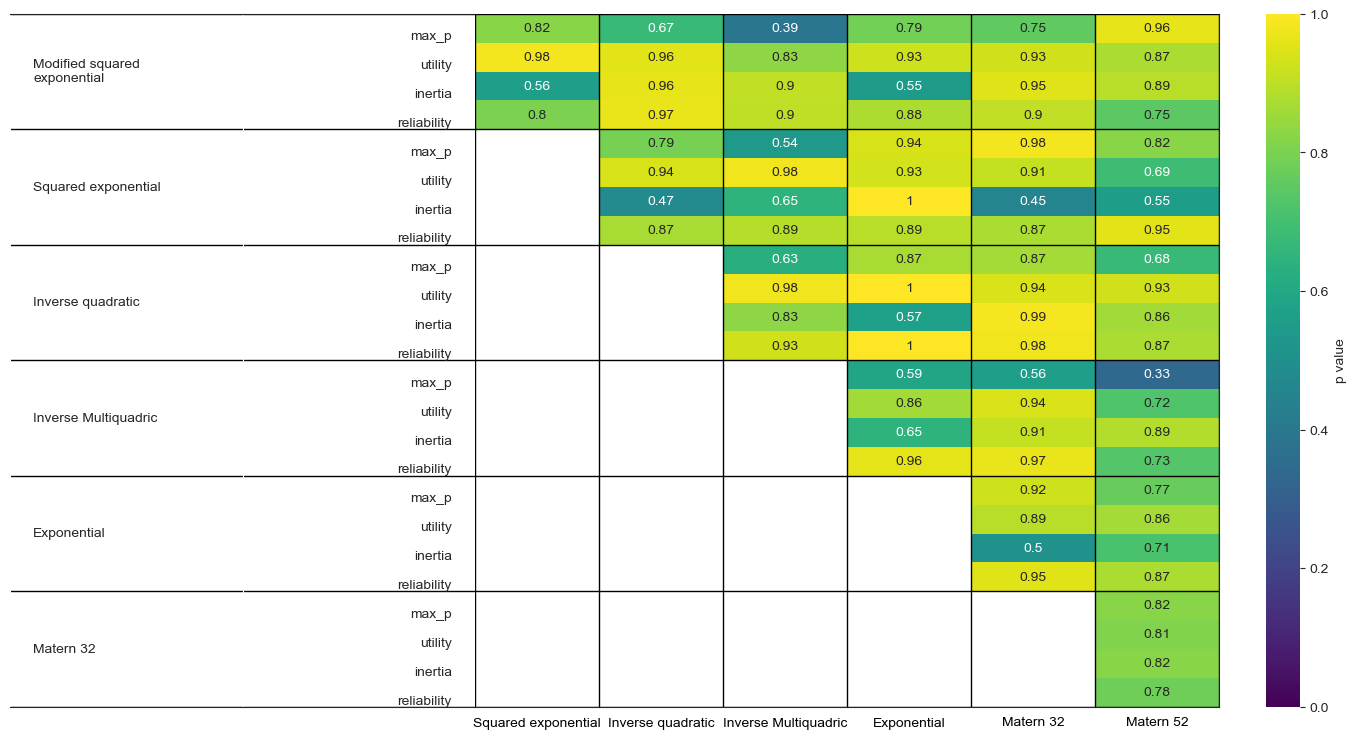

In [37]:
import matplotlib as mpl

gs = mpl.gridspec.GridSpec(
    1, 3, wspace=0, hspace=0, width_ratios=[1, 1, 4]
)

row_rbfs = results.index.get_level_values(0).unique()

n_obj = len(objectives)
n_rbf = len(row_rbfs)

sns.set_style('white')

fig = plt.figure(figsize=(18,9))

ax1 =  fig.add_subplot(gs[0, 0])
ax2 =  fig.add_subplot(gs[0, 1])
ax3 =  fig.add_subplot(gs[0, 2])

ax1.set_ylim(ymin=0, ymax=n_rbf*n_obj)
ax1.set_xlim(xmin=0, xmax=1)

ax2.set_ylim(ymin=0, ymax=n_rbf*n_obj)
ax2.set_xlim(xmin=0, xmax=1)

for ax in [ax1, ax2]:
    for spine in ['left', 'right']:
        ax.spines[spine].set_color("white")
    ax.set_xticks([])
    ax.set_yticks([])


# y labels rbfs
for i, rbf in enumerate(row_rbfs[::-1]):
    ax1.text(0.1, (i*n_obj)+n_obj/2, rbf, va='center')

    # y labels outcomes
    for j, obj in enumerate(objectives[::-1]):
        ax2.text(0.9, (i*n_obj)+(j), obj, va='bottom', ha='right')
    
    
sns.heatmap(results, annot=True, cmap='viridis', ax=ax3, mask=(results==0), vmin=0,
            vmax=1, cbar_kws={'label': 'p value'})

for i in range(0, n_obj*(n_rbf+1), n_obj):
    ax3.plot([0, n_rbf], [i, i], lw=1, color="black")
    ax1.plot([0, 1], [i, i], lw=1, color="black")        
    ax2.plot([0, 1], [i, i], lw=1, color="black")            
    
for i in range(0, (len(rbfs)+1)):
    ax3.plot([i, i], [0, n_obj*n_rbf], lw=1, color="black")    

ax3.tick_params(axis='x', colors='black')

ax3.spines['bottom'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax3.set_yticks([])
ax3.set_ylabel('')


plt.show()

In [36]:
results.index.get_level_values(0).unique()[0]

'Modified squared\nexponential'